In [1]:
# Add the parent directory to the path
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Import numpy and ShortestPathGrid class
import numpy as np
from src.models.ShortestPathGrid import ShortestPathGrid

In [2]:
# Generate data
m, n = (5, 5)  # grid size
# Create a random cost array for the grid
cost = np.arange((m-1)*n + m*(n-1))
np.random.shuffle(cost)
# Initialize the ShortestPathGrid with the cost array
grid = ShortestPathGrid(m, n, cost=cost)

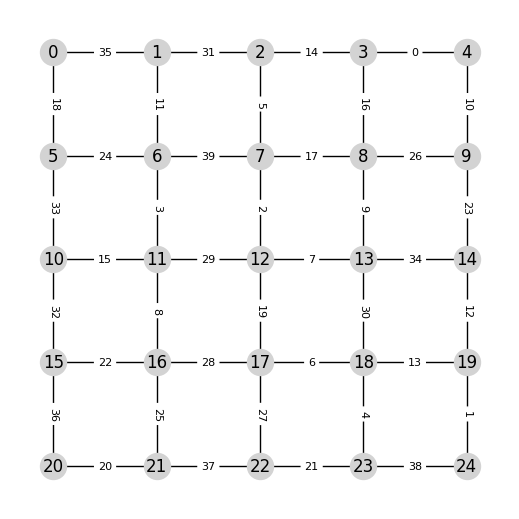

In [3]:
# Visualize the grid and edge costs
grid.visualize()

In [4]:
# Set source and target of optimization
source = 1 # source node
target = 23 # target node

# Solve the shortest path problem
sol, obj = grid.solve(source=source, target=target)

Optimal objective: 60


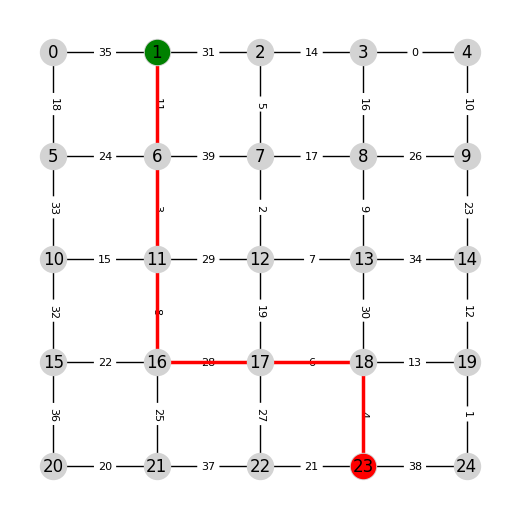

In [5]:
# Visualize the shortest path
grid.visualize(source=source, target=target, color_edges=sol)
print("Optimal objective:", obj)

In [6]:
import pyepo

# Set parameters for data generation
num_train_data = 1000 # number of training data
num_test_data = 1000 # number of test data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width

# Generate data for shortest path problem
feats, costs = pyepo.data.shortestpath.genData(num_train_data+num_test_data, num_feat, (m,n), deg=deg, noise_width=e, seed=135)

In [7]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=num_test_data, random_state=42)

In [8]:
from src.models.LinearRegression import LinearRegression

# Instantiate linear regression model
model = LinearRegression(num_feat=num_feat, num_edges=grid.get_num_edges())

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# Choose loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [10]:
# Data loading
train_data = torch.utils.data.TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(c_train).float())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_data = torch.utils.data.TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(c_test).float())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

In [11]:
from src.models.trainer import Trainer

# # 2) Build your two‐stage network:
# #    e.g. lr = LinearRegression(...); opt = ShortestPath(...)
# #    maybe wrap them in a single nn.Module
# model = MyOptNetPipeline(linear_model=model, opt_model=opt)

# Train linear regression model
trainer = Trainer(model, optimizer, criterion)
train_loss, test_loss = trainer.fit(train_loader, test_loader)


Epoch 000 | Train Loss: 1.4347 | Val Loss: 1.4580
Epoch 010 | Train Loss: 0.7436 | Val Loss: 0.7796
Epoch 020 | Train Loss: 0.4337 | Val Loss: 0.4708
Epoch 030 | Train Loss: 0.2942 | Val Loss: 0.3290
Epoch 040 | Train Loss: 0.2312 | Val Loss: 0.2636
Epoch 050 | Train Loss: 0.2025 | Val Loss: 0.2328
Epoch 060 | Train Loss: 0.1894 | Val Loss: 0.2182
Epoch 070 | Train Loss: 0.1835 | Val Loss: 0.2112
Epoch 080 | Train Loss: 0.1807 | Val Loss: 0.2077
Epoch 090 | Train Loss: 0.1794 | Val Loss: 0.2059
Epoch 100 | Train Loss: 0.1788 | Val Loss: 0.2050


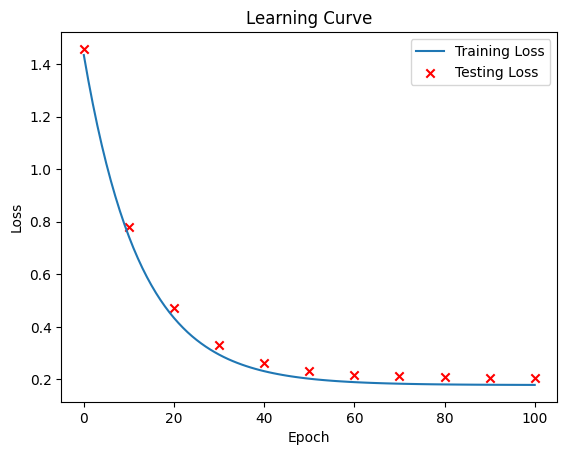

In [12]:
import matplotlib.pyplot as plt

# Plot learning curve and optionally test loss
plt.plot(train_loss, label='Training Loss')
if test_loss:
    plt.scatter(np.arange(len(test_loss))*trainer.n_epochs, test_loss, marker='x', color='red', label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [15]:
# init SPO+ loss
spop = pyepo.func.SPOPlus(grid)

Num of cores: 1
